# Transfer Learning with fastai

## Classify Chest X-Ray Images as Normal or Pneumonia.

### Data set: 5856 images


https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [1]:
from fastai import *
from fastai.vision import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from os import listdir
from os.path import isfile, join
from PIL import Image
%matplotlib inline

### Path to images

In [2]:
path = Path('/home/jupyter/.fastai/data/pneumonia/chest_xray')

## Training

In [3]:
src = (ImageItemList.from_folder(path/'train', folder='.', suffix='.jpeg') 
       .random_split_by_pct(0.3)
       .label_from_folder())

data = (src.transform(get_transforms(), size=224, bs=64)
        .databunch().normalize(imagenet_stats))

In [4]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 3663
Number of examples in validation: 1569


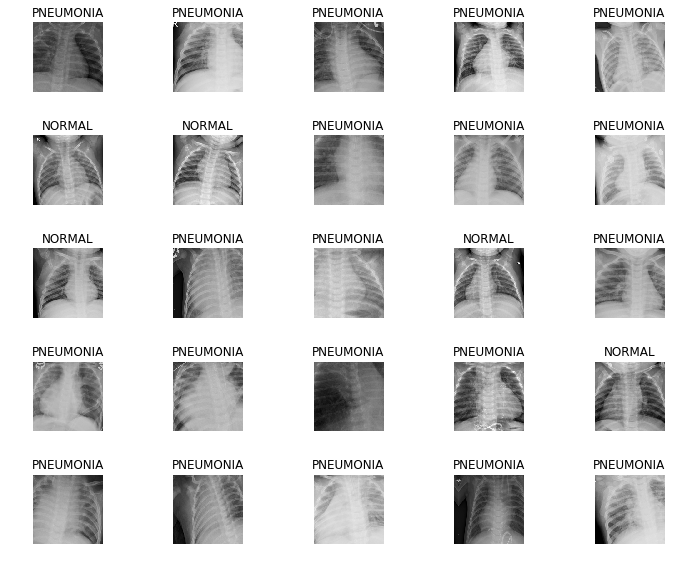

In [5]:
data.show_batch(rows=5, figsize=(10,8))

In [6]:
classes = data.classes
print(classes)

['NORMAL', 'PNEUMONIA']


## Learning

#### First 10 epochs on last layer

In [7]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [8]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate
1,0.513134,0.311740,0.118547
2,0.290756,0.247208,0.075844
3,0.224145,0.177664,0.064372
4,0.179882,0.131516,0.050988
5,0.142757,0.156069,0.060548
6,0.132366,0.160705,0.056724
7,0.122127,0.124718,0.047164
8,0.114162,0.114549,0.042702
9,0.114414,0.108157,0.040790
10,0.102377,0.111632,0.042702


In [9]:
learn.save('pneumonia-1')

In [10]:
#learn.load('pneumonia-1')

#### Next 20 epochs on the last 10 layers

In [11]:
learn.unfreeze()
learn.freeze_to(-10)
#learn.lr_find()
#learn.recorder.plot()
learn.fit_one_cycle(20, max_lr=slice(3e-6,3e-5))

epoch,train_loss,valid_loss,error_rate
1,0.099557,0.114043,0.044614
2,0.099431,0.120545,0.045889
3,0.085206,0.114489,0.042702
4,0.095134,0.105081,0.042065
5,0.087311,0.100336,0.039516
6,0.081737,0.104051,0.043977
7,0.074973,0.093357,0.036329
8,0.065167,0.098015,0.035054
9,0.063142,0.101310,0.038241
10,0.056122,0.079168,0.029318


In [12]:
learn.save('pneumonia-2')

In [13]:
#learn.load('pneumonia-2')

### Confusion matrix on the validation set

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

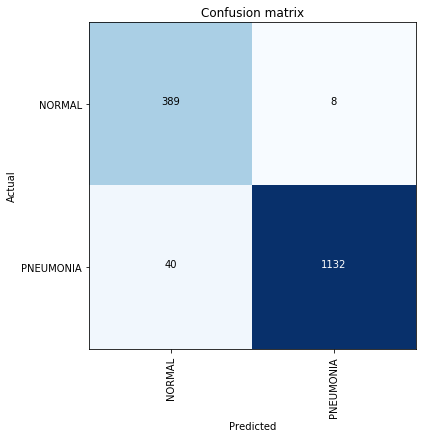

In [15]:
interp.plot_confusion_matrix(figsize=(6,6))

In [16]:
cm = interp.confusion_matrix()
print(pd.DataFrame(cm, columns=[classes], index=[classes]).to_string())

          NORMAL PNEUMONIA
NORMAL       389         8
PNEUMONIA     40      1132


#### Confusion matrix for classes with issues, normalizing by row

In [17]:
cm_norm = (cm.T/(cm.sum(axis=1))).T
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

          NORMAL PNEUMONIA
NORMAL      0.98      0.02
PNEUMONIA   0.03      0.97


#### Confusion matrix for classes with issues, normalizing by column

In [18]:
cm_norm = (cm/(cm.sum(axis=0)))
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

          NORMAL PNEUMONIA
NORMAL      0.91      0.01
PNEUMONIA   0.09      0.99


### Accuracy, precision, recall, f1-score

In [19]:
accuracy = (cm[0,0]+cm[1,1])/cm.sum()
precision = cm[1,1]/sum(cm[:,1])
recall = cm[1,1]/sum(cm[1,:])
f1score = 2*precision*recall/(precision+recall)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("F1-score", f1score)

accuracy 0.9694072657743786
precision 0.9929824561403509
recall 0.9658703071672355
F1-score 0.9792387543252596


## Now predict on Test set

In [20]:
src = (ImageItemList.from_folder(path, folder='.', suffix='.jpg') 
       .split_by_folder(train='train', valid='test')
       .label_from_folder())

data = (src.transform(get_transforms(flip_vert=True), size=224, bs=16)
        .databunch().normalize(imagenet_stats))

In [21]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 624


In [22]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [23]:
learn.load('/home/jupyter/.fastai/data/pneumonia/chest_xray/train/models/pneumonia-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5232 items)
[Category PNEUMONIA, Category PNEUMONIA, Category PNEUMONIA, Category PNEUMONIA, Category PNEUMONIA]...
Path: /home/jupyter/.fastai/data/pneumonia/chest_xray
x: ImageItemList (5232 items)
[Image (3, 840, 1230), Image (3, 809, 1450), Image (3, 800, 1352), Image (3, 600, 1008), Image (3, 940, 1242)]...
Path: /home/jupyter/.fastai/data/pneumonia/chest_xray;

Valid: LabelList
y: CategoryList (624 items)
[Category PNEUMONIA, Category PNEUMONIA, Category PNEUMONIA, Category PNEUMONIA, Category PNEUMONIA]...
Path: /home/jupyter/.fastai/data/pneumonia/chest_xray
x: ImageItemList (624 items)
[Image (3, 856, 1120), Image (3, 592, 1008), Image (3, 696, 1160), Image (3, 648, 912), Image (3, 640, 952)]...
Path: /home/jupyter/.fastai/data/pneumonia/chest_xray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

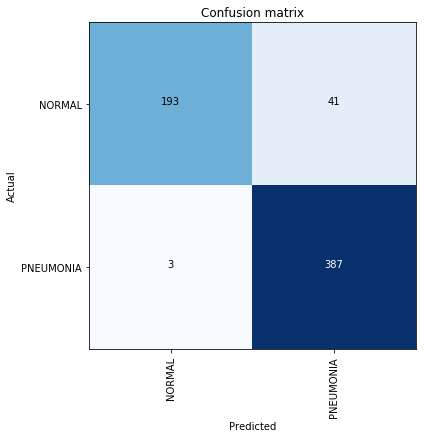

In [25]:
interp.plot_confusion_matrix(figsize=(6,6))

#### Confusion matrix for classes with issues, normalizing by row

In [26]:
cm = interp.confusion_matrix()
cm_norm = (cm.T/(cm.sum(axis=1))).T
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

          NORMAL PNEUMONIA
NORMAL      0.82      0.18
PNEUMONIA   0.01      0.99


#### Confusion matrix for classes with issues, normalizing by column

In [27]:
cm_norm = (cm/(cm.sum(axis=0)))
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

          NORMAL PNEUMONIA
NORMAL      0.98       0.1
PNEUMONIA   0.02       0.9


### Accuracy, precision, recall, f1-score (pneumonia being the positive class)

In [28]:
accuracy = (cm[0,0]+cm[1,1])/cm.sum()
precision = cm[1,1]/sum(cm[:,1])
recall = cm[1,1]/sum(cm[1,:])
f1score = 2*precision*recall/(precision+recall)
print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("F1-score", f1score)

accuracy 0.9294871794871795
precision 0.9042056074766355
recall 0.9923076923076923
F1-score 0.9462102689486552
